In [1]:
import os
import sys
import time
from datetime import date
from datetime import datetime
import time
import json
import platform

import stoneburner
#//*** Custom Functions:
#//*** mr_clean_text(input_series)
#//*** tokenize_series(input_series)
#//*** remove_stop_words(input_series)

# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
subreddits = ["wallstreetbets", "stocks", "wallstreetbetsOGs", "spacs", "investing", "pennystocks", "stockmarket", "options", "robinhoodpennystocks", "wallstreetbetsnew", "smallstreetbets"]
filepath = "./data/"
filename_suffix = "_comments.csv.zip"
#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [2]:
#//*** Input_filename: Comments to Process.
#//*** This will eventually be a list of files
#input_filename  =".\\data\\wallstreetbets_comments.csv.zip"
interval="daily"

#//*** Path to processed files
#output_filename = f"./data/processed_reddit_v4_{interval}.csv.zip"
output_filename = f"./ignore_folder/training_amc_{interval}.csv"

#//*** Path to the stock ticker JSON file
stock_ticker_filename = "./data/stock_tickers.json"

#//*** Convert Path to Mac formatting if needed
#if platform.system() == 'Darwin':
#    output_filename = output_filename.replace("\\","/")
#    stock_ticker_filename = stock_ticker_filename.replace("\\","/")

#//*** Load the Stock Tickers
f = open(stock_ticker_filename, "r")
symbols = json.loads(f.read())['symbols']

symbols = ["amc"]
f.close()

process_tfidf = False

print(symbols)
#//*** Convert symbols to lower case
symbols = [x.lower() for x in symbols]



raw_df = pd.DataFrame()

start_time = time.time()

#//*** Load each Subreddit for Aggregation
for subreddit in subreddits:
    #//*** Filepath + subreddit name + csv.zip
    input_filename = filepath+subreddit+filename_suffix

    #//*** Convert Path to Mac formatting if needed
    #if platform.system() == 'Darwin':
    #    input_filename = input_filename.replace("\\","/")
   
    print(f"Reading Compressed CSV: {input_filename}")
    
    #//*** Read Each DataFrame and combine with raw_df
    raw_df = pd.concat([raw_df,pd.read_csv(input_filename,compression='zip' )])

#//*** Reset the index, since multiple indexes have been combined
raw_df.reset_index(drop=True, inplace=True)

print(f"Files Loaded: {round(time.time()-start_time,2)}s")
print(f"Total Records: {len(raw_df)}")
    

['amc']
Reading Compressed CSV: ./data/wallstreetbets_comments.csv.zip
Reading Compressed CSV: ./data/stocks_comments.csv.zip
Reading Compressed CSV: ./data/wallstreetbetsOGs_comments.csv.zip
Reading Compressed CSV: ./data/spacs_comments.csv.zip
Reading Compressed CSV: ./data/investing_comments.csv.zip
Reading Compressed CSV: ./data/pennystocks_comments.csv.zip
Reading Compressed CSV: ./data/stockmarket_comments.csv.zip
Reading Compressed CSV: ./data/options_comments.csv.zip
Reading Compressed CSV: ./data/robinhoodpennystocks_comments.csv.zip
Reading Compressed CSV: ./data/wallstreetbetsnew_comments.csv.zip
Reading Compressed CSV: ./data/smallstreetbets_comments.csv.zip
Files Loaded: 49.25s
Total Records: 4432533


In [3]:
raw_df['body'] = raw_df['body'].astype('str')

#//*** Convert UTC to date (not datetime)
#//** Second pass goes from 12-21 to 4-19
try:
    raw_df['created_utc'] = raw_df['created_utc'].apply(lambda x: datetime.fromtimestamp(x))
except:
    print()
    
#//*** Keep just date and body fields
raw_df = raw_df[['created_utc','body']]
raw_df

,created_utc,body
0,2012-04-11 09:46:43,This is a fantastic idea! I'll toss mine up in...
1,2012-04-11 10:39:08,INTC is on 4/17
2,2012-04-11 11:02:31,"straddle, call, straddle, put, put, put, strad..."
3,2012-04-11 11:47:11,"GMCR falls, GOOG falls *slightly*, GRPN will g..."
4,2012-04-11 12:44:33,CROX 4/26\n\nBZH 5/1\n\ni'm expecting both to ...
...,...,...
4432528,2021-06-30 18:34:33,"Jun 30, 9.30pm EST.\n\n \nI just saw this pos..."
4432529,2021-06-30 19:08:36,Good run through. The mill is running and we’r...
4432530,2021-06-30 20:11:10,Back to normal not there yet
4432531,2021-06-30 20:16:51,💎👐🚀🚀🚀🚀


In [4]:
raw_df

,created_utc,body
0,2012-04-11 09:46:43,This is a fantastic idea! I'll toss mine up in...
1,2012-04-11 10:39:08,INTC is on 4/17
2,2012-04-11 11:02:31,"straddle, call, straddle, put, put, put, strad..."
3,2012-04-11 11:47:11,"GMCR falls, GOOG falls *slightly*, GRPN will g..."
4,2012-04-11 12:44:33,CROX 4/26\n\nBZH 5/1\n\ni'm expecting both to ...
...,...,...
4432528,2021-06-30 18:34:33,"Jun 30, 9.30pm EST.\n\n \nI just saw this pos..."
4432529,2021-06-30 19:08:36,Good run through. The mill is running and we’r...
4432530,2021-06-30 20:11:10,Back to normal not there yet
4432531,2021-06-30 20:16:51,💎👐🚀🚀🚀🚀


In [5]:
for symbol in symbols:
    stock_df = pd.read_csv(f"./stocks/{symbol}_{interval}.csv.zip")
    stock_df
    
    if 'date' in stock_df.columns:
        stock_df['date'] = pd.to_datetime(stock_df['date'])
        stock_df = stock_df.rename(columns={'date':'time'})
    else:
        stock_df['time'] = pd.to_datetime(stock_df['time'])
    
    #//*** Keeping this cool chunk of code as a reference
    #stock_df['time'] = stock_df['time'].apply(lambda x: x.timestamp())
    
    #//*** Remove Comments older than the first stock price
    raw_df = raw_df[ raw_df['created_utc'] >= stock_df['time'].min() ]
    
    #//*** Remove Stock Prices older than the first Comments price
    stock_df = stock_df[ stock_df['time'] >= raw_df['created_utc'].min() ]
    
    #//*** Remove Stock Prices older than the last Comments
    stock_df = stock_df[ stock_df['time'] <= raw_df['created_utc'].max() ]
    
    #//*** Reorder Comments by date
    raw_df.sort_values('created_utc',inplace=True,ignore_index=True)
    
    #//*** Reorder Stocks by date
    stock_df.sort_values('time',inplace=True, ignore_index=True)
stock_df

C:\Users\family\anaconda3\envs\plaidml\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,time,symbol,open,high,low,close,volume
0,2014-04-11,amc,22.73,23.71,21.91,23.60,581500
1,2014-04-14,amc,23.88,24.01,23.51,23.59,305200
2,2014-04-15,amc,23.66,23.94,22.17,22.41,264700
3,2014-04-16,amc,22.45,22.63,22.02,22.51,191000
4,2014-04-17,amc,22.44,22.65,21.68,22.30,367100
...,...,...,...,...,...,...,...
1813,2021-06-24,amc,57.98,58.76,55.66,56.70,80351219
1814,2021-06-25,amc,55.75,56.29,52.97,54.06,77596927
1815,2021-06-28,amc,55.10,59.36,54.33,58.11,99310240
1816,2021-06-29,amc,59.06,61.00,56.18,56.43,63604135


In [6]:
stock_df

,time,symbol,open,high,low,close,volume
0,2014-04-11,amc,22.73,23.71,21.91,23.60,581500
1,2014-04-14,amc,23.88,24.01,23.51,23.59,305200
2,2014-04-15,amc,23.66,23.94,22.17,22.41,264700
3,2014-04-16,amc,22.45,22.63,22.02,22.51,191000
4,2014-04-17,amc,22.44,22.65,21.68,22.30,367100
...,...,...,...,...,...,...,...
1813,2021-06-24,amc,57.98,58.76,55.66,56.70,80351219
1814,2021-06-25,amc,55.75,56.29,52.97,54.06,77596927
1815,2021-06-28,amc,55.10,59.36,54.33,58.11,99310240
1816,2021-06-29,amc,59.06,61.00,56.18,56.43,63604135


In [7]:
#//*** Group the stock values by time, this is essentially like itterrows()
groups = stock_df.groupby('time')


In [8]:
cdf = raw_df.copy()

#https://www.geeksforgeeks.org/how-to-iterate-over-dataframe-groups-in-python-pandas/
key_list = list(groups.groups.keys())

bin_df = pd.DataFrame()

start_time = time.time()
comment_min_time = raw_df['created_utc'].min()
comment_max_time = raw_df['created_utc'].max()
min_index = 0
start_time = time.time()
print("Processing...")
for x in range(len(key_list)-1):
    
    #//*** Get a single line of stocks as a dataframe
    loop_stocks_df = groups.get_group((key_list)[x]).copy()  
    
    t1 = groups.get_group((key_list)[x])['time'].iloc[0]
    t2 = groups.get_group((key_list)[x+1])['time'].iloc[0]
    
    #search through cdf to find comments that are between t1 and t2
    #if len(cdf[ (cdf['created_utc'] > t1) & (cdf['created_utc'] < t2) ]) > 0:
    #temp_df = cdf.iloc[min_index:]
    temp_df = cdf[(cdf['created_utc'] >= t1) & (cdf['created_utc'] < t2) ]
    
    if len(temp_df) == 0:
            #//*** No COmments on this Date
            loop_stocks_df['body'] = " "
            loop_stocks_df['comment_count'] = 0
    else:
        #print(temp_df.index[0])
        #print(temp_df.index[-1])
        #print(cdf.iloc[temp_df.index[0]:temp_df.index[-1]])
        temp_df = cdf.iloc[temp_df.index[0]:temp_df.index[-1]]
        #//*** Get all the body comments and combine them
        loop_stocks_df['body'] = " ".join(list(temp_df['body']))

        #//*** Get a comment count, BC IDK Y
        loop_stocks_df['comment_count'] = len(temp_df['body']) 
    
    #//*** Secret to speeding up algorithm. Get the Index value of the last item found -1. 
    #//*** When Searching above, start the search from this index. Seems to speed things up. Since we're skipping past elements that we've already found
    if len(temp_df) > 0: 
        min_index = temp_df.index[-1]

        
    
    #//*** Add the single line of loop_stocks_df to bin_df    
    bin_df = pd.concat([bin_df,loop_stocks_df])
        #print(loop_df.index)
        #print(loop_df)
        #cdf = cdf.drop(index=loop_df.index)
    
        
    
    #lengroup
   
    #if x > 1000:
    #    bin_df.head(20)
    #    print("break")
    #    break
print(f"Elapsed {round(time.time()-start_time,2)}")

#print("Merging")
#bin_df = pd.merge(bin_df,stock_df,left_on='bin_time',right_on='time')

#del bin_df['bin_time']
#print(bin_df)
print("Pickling")

#bin_df.to_pickle(output_filename,compression='zip')
print("Done!")

Processing...
Elapsed 70.28
Pickling
Done!


In [9]:
tdf = bin_df[bin_df['time'] >= pd.to_datetime("2020-01-01")]
tdf



,time,symbol,open,high,low,close,volume,body,comment_count
1441,2020-01-02,amc,7.30,7.56,7.230,7.46,4545935,Look at you tryna get free stocks lol smart Co...,1672
1442,2020-01-03,amc,7.45,7.60,7.305,7.32,2217959,Fake news... they don’t wanna be held for insi...,2282
1443,2020-01-06,amc,7.25,7.30,7.110,7.12,2903381,you act like the iPhone you’re holding isn’t m...,1851
1444,2020-01-07,amc,7.11,7.20,7.000,7.13,3206587,"But you see, it’s a cutting edge firm out of t...",1279
1445,2020-01-08,amc,7.11,7.15,6.610,6.62,6556979,Hmm that's why I asked my question. I don't g...,956
...,...,...,...,...,...,...,...,...,...
1812,2021-06-23,amc,57.04,61.10,56.800,58.30,116291804,Meme meta is basically selling overpriced opti...,11530
1813,2021-06-24,amc,57.98,58.76,55.660,56.70,80351219,Your time horizon is way too short for anythin...,12330
1814,2021-06-25,amc,55.75,56.29,52.970,54.06,77596927,TLDR: SRNE receives approval to import covid-1...,27059
1815,2021-06-28,amc,55.10,59.36,54.330,58.11,99310240,"Me too, hate myself for buying a shit load of ...",10926


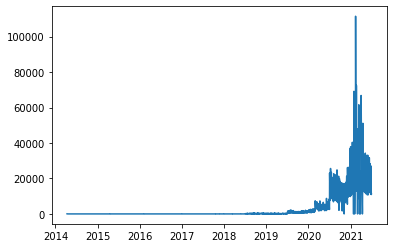

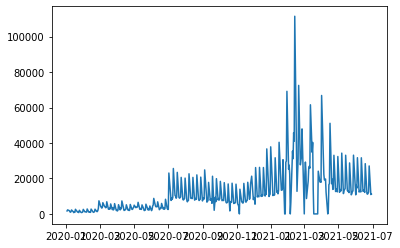

In [10]:
fig,ax = plt.subplots()

ax.plot(bin_df['time'],bin_df['comment_count'] )



    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

fig,ax = plt.subplots()

ax.plot(tdf['time'],tdf['comment_count'] )



    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()



In [11]:
#//***Aggreate Comments for Training
#//*** Build tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

#loop_list.append(tfidf.fit_transform(input_df['tfidf']))
tfidf_matrix = []
tfidf_list = []
tfidf = TfidfVectorizer()

print("Starting tfidf....")
start_time = time.time()
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(tdf['body'])


print(f"Built: {round(time.time()-start_time,2)}")

print(tfidf_matrix)
print

Starting tfidf....
Built: 86.4
  (0, 281443)	0.00030611349672286635
  (0, 245381)	0.0017126839108236192
  (0, 105159)	0.0003542084655873561
  (0, 181969)	0.0005910496805570602
  (0, 208781)	0.0015224092873656852
  (0, 94623)	0.0003291090212008266
  (0, 283055)	0.0003883721639328727
  (0, 385303)	0.00041376496788701213
  (0, 409283)	0.00029727059209234415
  (0, 23865)	0.0003195067995828591
  (0, 399648)	0.0007570547663323831
  (0, 155983)	0.00029965418092375173
  (0, 385284)	0.00033178717176708775
  (0, 377319)	0.00039619981359425427
  (0, 332670)	0.0007328177167562861
  (0, 138997)	0.0003754517436285288
  (0, 305130)	0.0005256737980703497
  (0, 249414)	0.0003692126510708042
  (0, 413048)	0.0006616902394883023
  (0, 135149)	0.0003127284735727467
  (0, 172151)	0.0005980587827519876
  (0, 151595)	0.0004054278507862134
  (0, 362365)	0.0007141364792686097
  (0, 283034)	0.0005758759357493903
  (0, 319574)	0.00030611349672286635
  :	:
  (375, 453906)	0.054935103307817826
  (375, 95065)	0.0495

<function print>

In [12]:

tdf

,time,symbol,open,high,low,close,volume,body,comment_count
1441,2020-01-02,amc,7.30,7.56,7.230,7.46,4545935,Look at you tryna get free stocks lol smart Co...,1672
1442,2020-01-03,amc,7.45,7.60,7.305,7.32,2217959,Fake news... they don’t wanna be held for insi...,2282
1443,2020-01-06,amc,7.25,7.30,7.110,7.12,2903381,you act like the iPhone you’re holding isn’t m...,1851
1444,2020-01-07,amc,7.11,7.20,7.000,7.13,3206587,"But you see, it’s a cutting edge firm out of t...",1279
1445,2020-01-08,amc,7.11,7.15,6.610,6.62,6556979,Hmm that's why I asked my question. I don't g...,956
...,...,...,...,...,...,...,...,...,...
1812,2021-06-23,amc,57.04,61.10,56.800,58.30,116291804,Meme meta is basically selling overpriced opti...,11530
1813,2021-06-24,amc,57.98,58.76,55.660,56.70,80351219,Your time horizon is way too short for anythin...,12330
1814,2021-06-25,amc,55.75,56.29,52.970,54.06,77596927,TLDR: SRNE receives approval to import covid-1...,27059
1815,2021-06-28,amc,55.10,59.36,54.330,58.11,99310240,"Me too, hate myself for buying a shit load of ...",10926


In [13]:

offset_target = 1

#/***Reorder and drop tdf columns
tdf = tdf[['close','volume','open','high','low','comment_count','time']]
tdf.reset_index(drop=True, inplace=True)
start_time = time.time()
print(f"Begin Concat")
df = pd.concat([tdf,pd.DataFrame(tfidf_matrix.toarray())],axis=1)
print (f"Concat Done: {round(time.time()-start_time,2)}s")
#del df['body']
#del df['symbol']
#start_time = time.time()
#print(f"Writing to csv")
#output_filename = f"./ignore_folder/training_amc_{interval}.csv.zip"
#tdf.to_csv(output_filename,index=False)
#print (f"Written: {round(time.time()-start_time,2)}s")





print("Building Target Offset Columns...")
#//*** Build the target variables and intervals of stock prices. This is a single value determined by target)offset

#//*** create a list of nan values of x length
nan_list = list(np.empty( offset_target )* np.nan )

#//*** Create target variable Price which is stocks + x columns in advance
#//*** Takes the closing price starting at x and gets the remainder, this generates the offset
#//*** nan_list fills the missing x values with nans
target = list(df['close'][offset_target:]) + nan_list 
target = target[:offset_target*-1]
print(len(target))
df = df[:offset_target*-1]
print(df.shape)

print(f"Building Time Series")
#//*** Peel off Time. Used for graphing
time_series = df['time']
print(len(time_series))
del df['time']
t_cols = df.columns[:10]
df[t_cols]

Begin Concat
Concat Done: 1.07s
Building Target Offset Columns...
375
(375, 473479)
Building Time Series
375


,close,volume,open,high,low,comment_count,0,1,2,3
0,7.46,4545935,7.30,7.56,7.230,1672,0.011052,0.007104,0.000000,0.0
1,7.32,2217959,7.45,7.60,7.305,2282,0.003820,0.004214,0.000000,0.0
2,7.12,2903381,7.25,7.30,7.110,1851,0.001987,0.005976,0.000000,0.0
3,7.13,3206587,7.11,7.20,7.000,1279,0.001753,0.005623,0.000000,0.0
4,6.62,6556979,7.11,7.15,6.610,956,0.009957,0.001497,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
370,58.27,169494144,54.10,58.74,51.050,11129,0.001663,0.003065,0.000000,0.0
371,58.30,116291804,57.04,61.10,56.800,11530,0.002025,0.003708,0.000000,0.0
372,56.70,80351219,57.98,58.76,55.660,12330,0.001807,0.003834,0.000112,0.0
373,54.06,77596927,55.75,56.29,52.970,27059,0.002134,0.004952,0.000000,0.0


In [14]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

from keras.models import Sequential

#//*** Verify Plaid ML is working
import plaidml.keras

import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

plaidml.keras.install_backend()


import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

import tensorflow.keras.backend as K

K

<module 'tensorflow.keras.backend' from 'C:\\Users\\family\\anaconda3\\envs\\plaidml\\lib\\site-packages\\tensorflow\\keras\\backend\\__init__.py'>

In [ ]:
optimizer = optimizers.RMSprop(0.0099)
#create and fit the Regression network
def model_regr(dim_size,lrn_rate = 0.01, mntum = 0 ):
    #Intializing the RNN
    model = Sequential()
    #1st layer
    model.add(layers.Dense(100, activation='relu', input_shape=(dim_size,)))
    model.add(layers.Dense(100, activation='relu', input_shape=(dim_size,)))
    model.add(layers.Dense(100, activation='relu', input_shape=(dim_size,)))
    #network.add(layers.Dense(32, activation='relu'))
    #network.add(layers.Dense(1))
    #model.add(Dropout(0.2))
    #2nd layer
    #model.add(layers.Dense(dim_size, activation='relu'))
    #network.add(layers.Dense(dim_size, activation='relu'))
    #network.add(layers.Dense(dim_size, activation='relu'))
    #network.add(layers.Dense(dim_size/4, activation='relu'))
    #network.add(layers.Dense(dim_size/8, activation='relu'))
    #model.add(Dropout(0.2))
    #Adding the output layer
    model.add(layers.Dense(1))
    #model.compile(loss = 'mse', optimizer='adam', metrics=['mse','mae','mape'])
    #model.compile(loss = 'mse', optimizer='RMSprop', metrics=['mse','mae','mape'])
    model.compile(loss = 'mse', optimizer='adam', metrics=['mse','mae','mape'])
    return model

X,y = np.array(df), np.array(target)

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.33, shuffle=False)
#x_train =     np.array(df[:180])
#y_train = np.array(target[:180])
#x_test =     np.array(df[181:200])
#y_test = np.array(target[181:200])

start_time = time.time()
print(x_train.shape[1])
regr = model_regr(x_train.shape[1],lrn_rate=0.01, mntum=0)
history = regr.fit(x_train, y_train, batch_size=1, verbose=1, epochs=10)
print(f"Run time internal GPU: {time.time()-start_time}")
result = regr.predict(x_test)
display_size = 40

fig,ax = plt.subplots()

ax.plot(range(len(y_test)),y_test )
ax.scatter(range(len(result)),result,color='red' )


    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

print(history.history.keys())

for x in history.history.keys():
    plt.plot(history.history[x],label=x)
#plt.plot(history.history['val_loss'])
    plt.title(x)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

473478
Epoch 1/10
251/251 [==============================] - 53s 205ms/step - loss: 102524515.1905 - mse: 102524515.1905 - mae: 5746.8345 - mape: 169417.7405
Epoch 2/10
251/251 [==============================] - 52s 209ms/step - loss: 2597967.1747 - mse: 2597967.1747 - mae: 881.5933 - mape: 24316.5072
Epoch 3/10
171/251 [===================>..........] - ETA: 17s - loss: 284755.3513 - mse: 284755.3513 - mae: 210.3906 - mape: 6067.7944

In [15]:
"""
#This is cool but likely a dead end

def recurse_search(needle,haystack):

    #print(f"recurse: {needle} {len(haystack)}")

    if len(haystack) < 10:
        #print("10 Stack")
        #print(haystack)
        return haystack

    half_dex = int(len(haystack) / 2)

    if needle >= haystack[half_dex]:
        return recurse_search(needle,haystack[half_dex:])
    else:
        return recurse_search(needle,haystack[:half_dex])

print("!")    
def get_bin_time(needle,haystack):
    
    small_stack = recurse_search(needle,haystack)
    for index in range(len(haystack)):
        
        
        if index+1 > len(haystack):
            #print(haystack[index])
            return haystack[index]

        if (needle > haystack[index]):
            if needle < haystack[index+1]: 
               # print(f"{index}:{len(haystack)} [{haystack[index]} > {needle} < {haystack[index+1]}]")

                return haystack[index]

    

#//*** Bin comments into times centered around pricing
bin_time = []
print("Binning Times")
start_time = time.time()
#raw_df['bin_time'] = raw_df['created_utc'].sort_values().apply(lambda x: get_bin_time(x,stock_times))


for x in comment_times:
    
    bin_time.append(get_bin_time(x,stock_times))
    if len(bin_time) > 100000:
        break
print(f"Binned {round(time.time()-start_time,2)}")
    
"""
print()